# Simple Loopy Belief Propagation

This is an example of simple loopy belief propagation on a discrete-valued graph. When a graph has loops, belief propagation is approximate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Problem Setup

We'll use image denoising as an example. We can represent the image as a Markov Random Field:

<img src="pixel_mrf.png" alt="drawing" width="20%"/>

The white nodes are the hidden pixel values we want to infer, in this case the denoised image, and the grey nodes are the observed pixels, in this case the noisy image. For our denoising application, we want to encourage neighbouring nodes to have the same value, to remove outliers. We also want to encourage the pixels to match the observation.

We'll consider discretely valued pixels only. In this example, the pixels can take on two values, -1 or +1.

First, we create the target image we want to infer:

In [2]:
im_size = 100

min_, max_ = -10, 10
x = np.arange(min_,max_,(max_-min_)/im_size)
y = np.arange(min_,max_,(max_-min_)/im_size)
X, Y = np.meshgrid(x, y)

data = -1*np.sin(X.reshape(-1,1)).reshape(X.shape)*np.cos(Y.reshape(-1,1)).reshape(X.shape)
data[data<=-0.5] = -1
data[data>-0.5] = 1
data = data.astype(int)

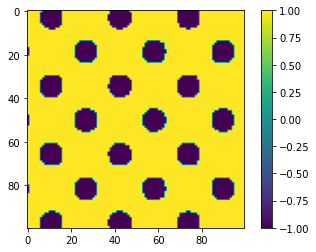

In [3]:
plt.imshow(data)
plt.colorbar()
plt.show()

We add some noise to it to create the "noisy" observation, still with values either -1 or +1.

In [4]:
noise = np.random.binomial(1, 0.15, size=(im_size,im_size))*-1
noise[noise==0] = 1
noisy_data = data * noise

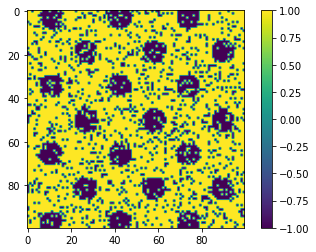

In [5]:
plt.imshow(noisy_data)
plt.colorbar()
plt.show()

## Belief Propagation

An MRF can be represented by a product of clique potentials:

$$p(X,Y) = \prod_{i \in nodes}\phi_i(x_i, z_i)\prod_{(i,j) \in edges}\psi_i(x_i, x_j)$$

In belief propagation, the goal is to solve for the marginal belief at each hidden node, $bel(x_i)$, given by:

$$bel(x_i) \propto \phi_i(x_i, z_i) \prod_{j \in nbr(i)} m_{j\to i}(x_i)$$

The messages are composed as follows:

$$m_{j\to i}(x_i) = \sum_{x_j}\phi_j(x_j, z_j) \psi_{ij}(x_i, x_j)\prod_{k \in nbr(j) \backslash i} m_{k\to j}(x_j)$$

The sum marginalizes out the neighbour nodes from the joint probability. 

Since this graph has loops, we can't perform exact inference by recursing through the graph until we reach a leaf node, so we use $m_{k\to j}^{t-1}(x_j)$ to calculate $m_{j\to i}^t(x_i)$. This is what makes the BP "loopy."

The message passing is illustrated in the drawing below, where the red arrows are the incoming messages $m_{j\to i}^t$, and the blue arrows are the incoming messages $m_{k\to j}^{t-1}(x_j)$, for one of the neighbours.

<img src="msg_pass.png" alt="Message Passing" width="30%"/>

### Potential Functions

The potential $\phi_i(x_i, z_i)$ is the unary potential, and $\psi_{ij}(x_i, x_j)$ is the pairwise potential. 

#### Pairwise Potential

Since we want to denoise the image, we want to encourage neighbouring pixels to have the same pixel value, so we use a function that is maximized when the values are the same, and is small when they are different.

In [6]:
beta = 2
def pairwise(xi, xj):
    return np.exp(-beta * np.abs(xi - xj))

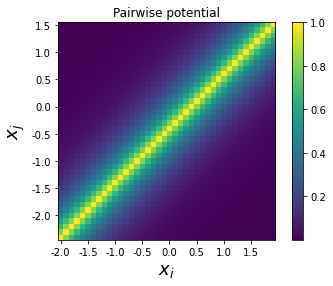

In [7]:
# Visualize the pairwise function.
delta = 0.1
xi = np.arange(-2, 2, delta)
xj = np.arange(-2, 2, delta)
X, Y = np.meshgrid(xi, xj)
Z = pairwise(X.reshape(-1),Y.reshape(-1)).reshape(X.shape)

plt.imshow(np.flip(Z, 0))
plt.xticks(np.arange(0, 40, 5), np.arange(-2, 2, 0.5))
plt.yticks(np.arange(0, 40, 5), np.flip(np.arange(-2, 2, 0.5)))
plt.xlabel("$x_i$", fontsize=18)
plt.ylabel("$x_j$", fontsize=18)
plt.title("Pairwise potential")
plt.colorbar()
plt.show()

#### Unary potential
The unary does the same thing, encouraging each pixel to align with the corresponding pixel in the observation.

In [8]:
gamma = 3.5
def unary(x, y):
    return np.exp(-gamma * np.abs(y - x))

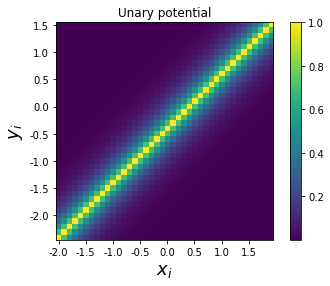

In [9]:
# Visualize the pairwise function.
delta = 0.1
x = np.arange(-2, 2, delta)
y = np.arange(-2, 2, delta)
X, Y = np.meshgrid(x, y)
Z = unary(X.reshape(-1),Y.reshape(-1)).reshape(X.shape)

plt.imshow(np.flip(Z, 0))
plt.xticks(np.arange(0, 40, 5), np.arange(-2, 2, 0.5))
plt.yticks(np.arange(0, 40, 5), np.flip(np.arange(-2, 2, 0.5)))
plt.xlabel("$x_i$", fontsize=18)
plt.ylabel("$y_i$", fontsize=18)
plt.title("Unary potential")
plt.colorbar()
plt.show()

### Graph Model

We'll connect the nodes to the pixels on each of their 4 sides, and consider all possible values the pixels can take.

Given image of size $(N, N)$, with $N^2$ total nodes, we'll consider the $K=2$ possible values each node can take, and the $M=4$ incoming messages. The belief at each node will be a distribution over the discrete pixel values at each pixel. It is represented by a matrix of size $(N, N, K)$. At each node, we'll store the n=messages going *out*, from node $j$ to node $i$, $m_{j\to i},  \in i = \{1...4\}$. The messages matrix wil therefore be size $(N, N, M, K)$.

As a convention, we'll choose the order *UP, RIGHT, DOWN, LEFT* for the messages, where the direction is from the perspective of the node passing the message, $x_j$.

In [10]:
# Graph params
N = im_size
X_VALS = [-1, 1]  # All the possible values of x.
K = len(X_VALS)  # Number of possible values of x.
NBR_DIRS = [[-1,0], [0,1], [1,0], [0,-1]]  # Direction order is UP, RIGHT, DOWN, LEFT.
M = len(NBR_DIRS)  # Number of neighbours

In [11]:
class MRF:
    def __init__(self, image, nbr_dirs, x_vals):
        self.N, _ = image.shape
        self.M, self.K = len(nbr_dirs), len(x_vals)
        
        self.obs = np.copy(image)
        self.image = np.copy(image)
        self.belief = np.ones((self.N, self.N, self.K)) / self.K
        self.messages = np.ones((self.N, self.N, self.M, self.K)) / self.K
        
        self.nodes = [[i, j] for j in range(self.N) for i in range(self.N)]
    
    def pos_inbounds(self, y, x):
        return (y >= 0 and y < self.N) and (x >= 0 and x < self.N)

    def get_neighbours(self, node):
        nbrs = [[ele1 + ele2 for ele1, ele2 in zip(nbr, node)] for nbr in NBR_DIRS]
        # Remove the neighbours which are out of the image bounds. Also remove the
        # neighbour we want to send the message to, if given.
        nbrs = [nbr if self.pos_inbounds(*nbr) else None for nbr in nbrs]
        return nbrs

    def obs_at(self, node):
        return self.obs[node[0], node[1]]
    
    def img_at(self, node):
        return self.image[node[0], node[1]]
    
    def msg_at(self, node, to):
        """Return the message from one node to another.
        
        Args:
            node: The node sending the message.
            to: The index of the node to send the message to, from
                the perspective of the sender. Indexing in order 
                (UP, RIGHT, DOWN, LEFT).
        """
        return self.messages[node[0], node[1], to]
    
    def pass_messages(self):
        new_messages = np.empty_like(self.messages)
        for node in self.nodes:
            # Update the message for each possible value of the node.
            for i, xi in enumerate(X_VALS):
                msg = np.zeros(self.M)
                # This is the integral.
                for j, xj in enumerate(X_VALS):
                    msg_base = unary(xj, self.obs_at(node)) * pairwise(xi, xj)
                    msg_part = np.full(self.M, msg_base)

                    # This part is the message product, for the second level neighbours.
                    for k, sub_nbr in enumerate(self.get_neighbours(node)):
                        if sub_nbr is None:
                            continue  # There is no neighbour in this direction.

                        # Get the message flowing into the first level neighbour.
                        # If this is the sub-neighbour in the UP direction (0), we
                        # want the message flowing to the DOWN direction (2).
                        to = (k + 2) % self.M
                        sub_msg = self.msg_at(sub_nbr, to)[j]  # Given that x = xj.

                        # This message is part of the product for all the messages,
                        # but we have to exclude xi, which is in the k direction from
                        # the perspective of xj.
                        msg_part[np.delete(np.arange(self.M), k)] *= sub_msg

                    msg += msg_part  # Top level sum.

                # Now we've got the message for this value of xi, for each incoming 
                # direction to xi.
                new_messages[node[0], node[1], :, i] = msg
        
        # Messages must be normalized, since they should represent probabilities.
        sum = new_messages.sum(axis=-1)
        sum[sum == 0] = 1 / len(X_VALS)  # Cheat, to ignore division by 0.
        self.messages = new_messages / np.expand_dims(sum, -1)

    def update_belief(self):
        for node in self.nodes:
            for i, xi in enumerate(X_VALS):
                bel = unary(xi, self.obs_at(node))
                # The product of all the incoming messages.
                for t, nbr in enumerate(self.get_neighbours(node)):
                    if nbr is None:
                        continue
                    to = (t + 2) % 4
                    bel *= self.msg_at(nbr, to)[i]

                self.belief[node[0], node[1], i] = bel

    def assign_max_marginals(self):
        self.image = np.argmax(self.belief, axis=-1)
        for i, xi in enumerate(X_VALS):
            self.image[self.image == i] = xi
        
    def energy(self):
        pair = 0
        for node in self.nodes:
            for nbr in self.get_neighbours(node):
                if nbr is None:
                    continue
                pair += abs(self.img_at(node) - self.img_at(nbr))
        return pair / np.prod(self.image.shape)


mrf = MRF(noisy_data, NBR_DIRS, X_VALS)

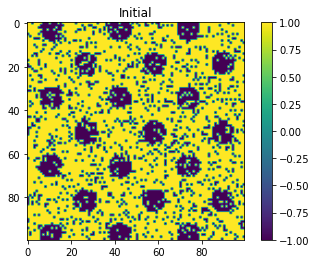

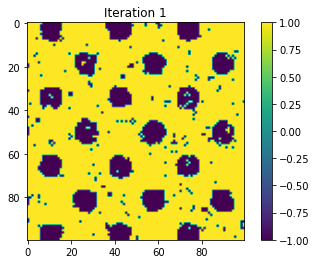

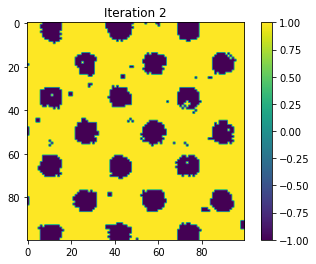

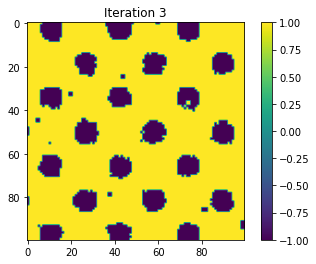

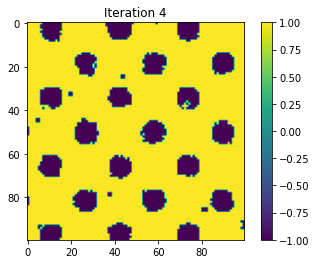

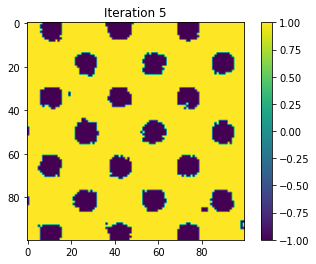

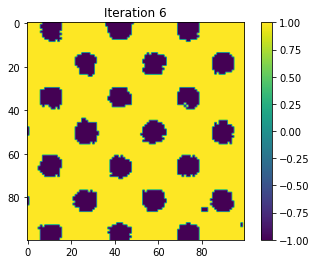

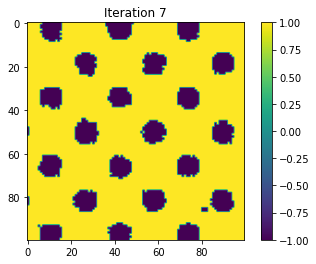

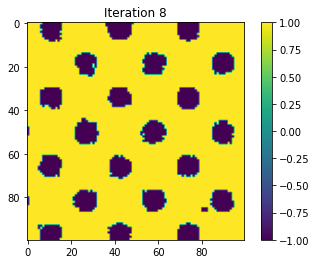

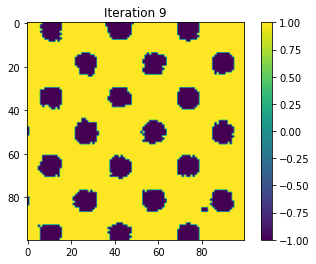

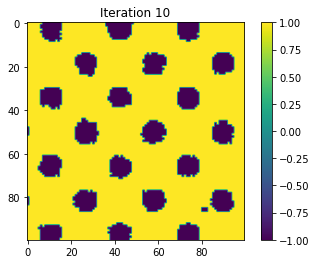

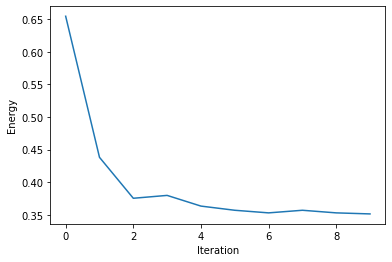

In [12]:
plt.title("Initial")
plt.imshow(mrf.image)
plt.colorbar()
plt.show()

energy = []
for i in range(10):
    mrf.pass_messages()
    mrf.update_belief()
    mrf.assign_max_marginals()

    energy.append(mrf.energy())

    plt.imshow(mrf.image)
    plt.colorbar()
    plt.title("Iteration {}".format(i + 1))
    plt.show()

plt.plot(np.arange(len(energy)), energy)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()